In [4]:
# Standard modules
import numpy as np
import nibabel as nib
import dipy.viz.regtools as rt
from dipy.align import VerbosityLevels
from dipy.align.transforms import regtransforms
from dipy.align.imaffine import (AffineMap,
                                 transform_centers_of_mass,
                                 MutualInformationMetric,
                                 AffineRegistration)
# Our modules
from dataset_info.info import get_neobrain
import pickle
import os
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)

Populating the interactive namespace from numpy and matplotlib


In [5]:
def dipy_align(static, static_grid2world, moving, moving_grid2world,
               transforms=None, prealign=None):
    r''' Full rigid registration with Dipy's imaffine module
    
    Here we implement an extra optimization heuristic: move the geometric
    centers of the images to the origin. Imaffine does not do this by default
    because we want to give the user as much control of the optimization
    process as possible.

    '''
    # Bring the center of the moving image to the origin
    c_moving = tuple(0.5 * np.array(moving.shape, dtype=np.float64))
    c_moving = moving_grid2world.dot(c_moving+(1,))
    correction_moving = np.eye(4, dtype=np.float64)
    correction_moving[:3,3] = -1 * c_moving[:3]
    centered_moving_aff = correction_moving.dot(moving_grid2world)

    # Bring the center of the static image to the origin
    c_static = tuple(0.5 * np.array(static.shape, dtype=np.float64))
    c_static = static_grid2world.dot(c_static+(1,))
    correction_static = np.eye(4, dtype=np.float64)
    correction_static[:3,3] = -1 * c_static[:3]
    centered_static_aff = correction_static.dot(static_grid2world)
    
    dim = len(static.shape)
    metric = MutualInformationMetric(nbins=32, sampling_proportion=0.3)
    level_iters = [10000, 1000, 100]
    affr = AffineRegistration(metric=metric, level_iters=level_iters)
    affr.verbosity = VerbosityLevels.DEBUG
    #metric.verbosity = VerbosityLevels.DEBUG
    
    # Registration schedule: center-of-mass then translation, then rigid and then affine
    if prealign is None:
        prealign = 'mass'
        
    if transforms is None:
        transforms = ['TRANSLATION', 'RIGID', 'AFFINE']
    
    sol = np.eye(dim + 1)
    for transform_name in transforms:
        transform = regtransforms[(transform_name, dim)]
        print('Optimizing: %s'%(transform_name,))
        x0 = None
        sol = affr.optimize(static, moving, transform, x0,
                              centered_static_aff, centered_moving_aff, starting_affine = prealign)
        prealign = sol.affine.copy()

    # Now bring the geometric centers back to their original location
    fixed = np.linalg.inv(correction_moving).dot(sol.affine.dot(correction_static))
    sol.set_affine(fixed)
    sol.domain_grid2world = static_grid2world
    sol.codomain_grid2world = moving_grid2world
    
    return sol

In [6]:
neo_fname = get_neobrain('train', 1, 'T2')
neo_nib = nib.load(neo_fname)
neo = neo_nib.get_data()
neo_affine = neo_nib.get_affine()

# Load atlas (with skull)
atlas_fname = get_neobrain('atlas', 'neo-withSkull', None)
atlas_nib = nib.load(atlas_fname)
atlas = atlas_nib.get_data()
atlas_affine = atlas_nib.get_affine()

# The first training volume dimensions are about  5cm x 5cm x 8cm
# The atlas  dimensions are about 7cm x 9cm x 11 cm
# Assuming isotropic scale, the atlas is about 1.5 times larger than
# the input image: 
iso_scale = (float(7*9*11)/float(5*5*8))**(1.0/3)
print(iso_scale)
    

1.51321654003


In [9]:
#We can use this to constraint the transformation to rigid
scale = np.eye(4)
scale[:3,:3] *= iso_scale

rigid_map_fname = 'atlas_towards_neo1_affine.p'

if os.path.isfile(rigid_map_fname):
    rigid_map = pickle.load(open(rigid_map_fname, 'r'))
else:
    transforms = ['RIGID', 'AFFINE']
    level_iters = [[10000, 1000, 100], [100]]
    rigid_map = dipy_align(neo, neo_affine, atlas, atlas_affine,
                           transforms=transforms,
                           level_iters=level_iters,
                           prealign=scale)
    pickle.dump(rigid_map, open(rigid_map_fname, 'w'))


atlas_resampled = rigid_map.transform(atlas)

In [10]:
pwd  # Check where are we saving the data

u'/home/omar/opt/segmentation/notebooks'

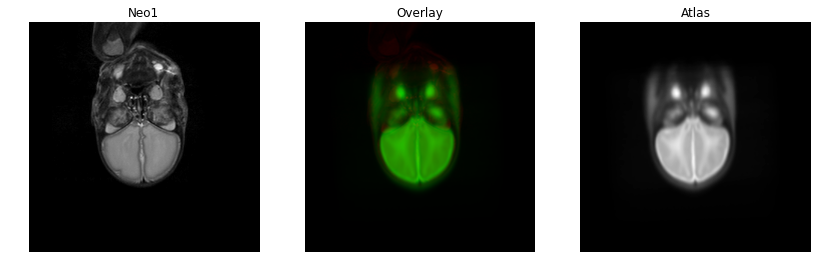

In [11]:
# Compare anterior coronal slices
rt.overlay_slices(neo, atlas_resampled, slice_type=2, slice_index=10, ltitle='Neo1', rtitle='Atlas');

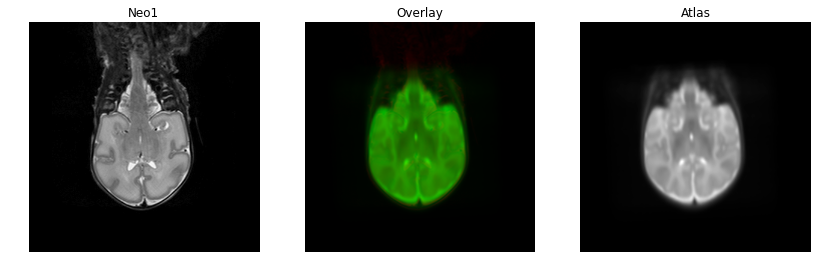

In [12]:
# Compare middle coronal slices
rt.overlay_slices(neo, atlas_resampled, slice_type=2, slice_index=25, ltitle='Neo1', rtitle='Atlas');

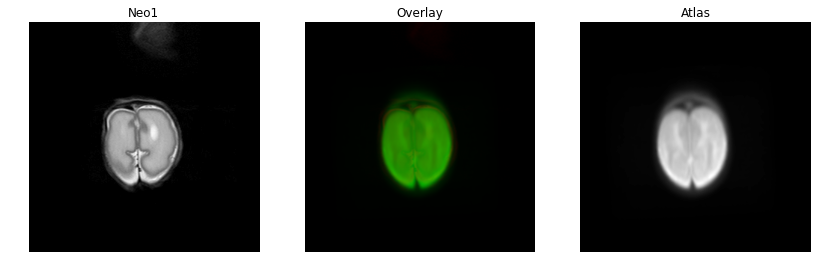

In [13]:
# Compare posterior coronal slices
rt.overlay_slices(neo, atlas_resampled, slice_type=2, slice_index=40, ltitle='Neo1', rtitle='Atlas');

In [14]:
# Load the peeled atlas
atlas_wcerebellum_fname = get_neobrain('atlas', 'neo-withCerebellum', None)
atlas_wcerebellum_nib = nib.load(atlas_wcerebellum_fname)
atlas_wcerebellum = atlas_wcerebellum_nib.get_data()
atlas_wcerebellum_affine = atlas_wcerebellum_nib.get_affine()

In [15]:
# Configure diffeomorphic registration
from dipy.align.metrics import CCMetric
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration


In [16]:
diff_map_name = 'atlas_towards_neo1_diff.p'
if os.path.isfile(diff_map_name):
    diff_map = pickle.load(open(diff_map_name, 'r'))
else:
    metric = CCMetric(3)
    sdr = SymmetricDiffeomorphicRegistration(metric)
    # The atlases are not aligned in physical space!! use atlas_affine instead of atlas_wcerebellum_affine
    diff_map = sdr.optimize(neo, atlas_wcerebellum, neo_affine, atlas_affine, prealign=rigid_map.affine)
    pickle.dump(diff_map, open(diff_map_name, 'w'))

In [17]:
atlas_wcerebellum_deformed = diff_map.transform(atlas_wcerebellum.astype(np.float32))
#atlas_wcerebellum.dtype

/home/omar/opt/dipy/dipy/align/imwarp.py:443: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  W = None if image_world2grid == 'identity' else image_world2grid
/home/omar/opt/dipy/dipy/align/imwarp.py:446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  S = None if out_grid2world == 'identity' else out_grid2world


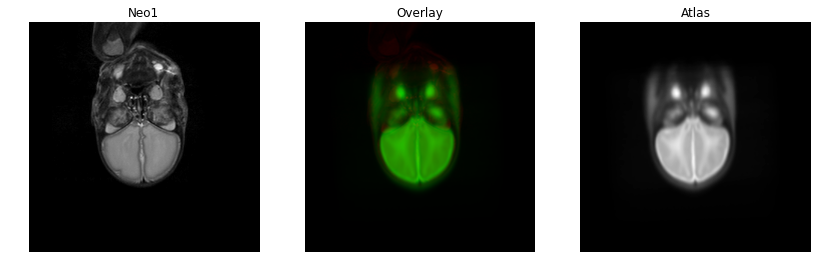

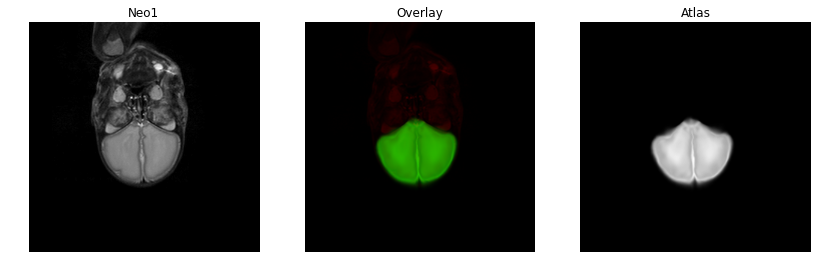

In [18]:
# Before and after diffeomorphic registration
rt.overlay_slices(neo, atlas_resampled, slice_type=2, slice_index=10, ltitle='Neo1', rtitle='Atlas');
rt.overlay_slices(neo, atlas_wcerebellum_deformed, slice_type=2, slice_index=10, ltitle='Neo1', rtitle='Atlas');

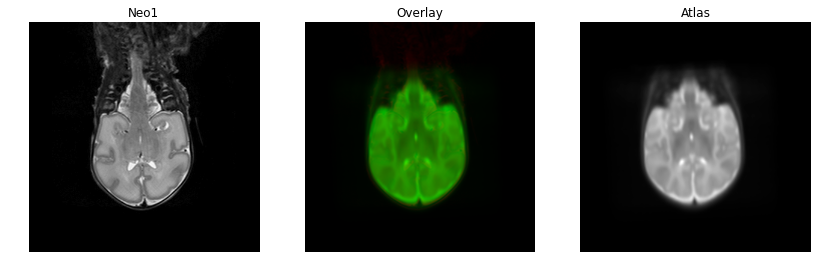

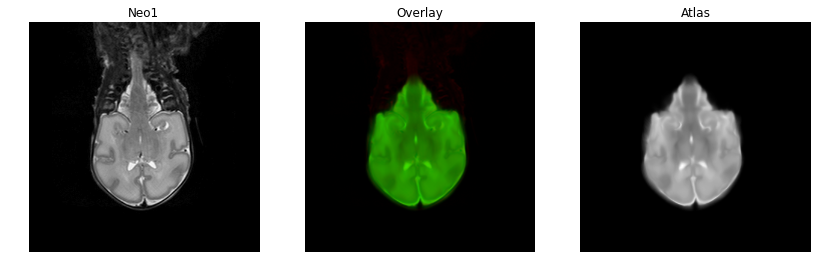

In [19]:
# Before and after diffeomorphic registration
rt.overlay_slices(neo, atlas_resampled, slice_type=2, slice_index=25, ltitle='Neo1', rtitle='Atlas');
rt.overlay_slices(neo, atlas_wcerebellum_deformed, slice_type=2, slice_index=25, ltitle='Neo1', rtitle='Atlas');

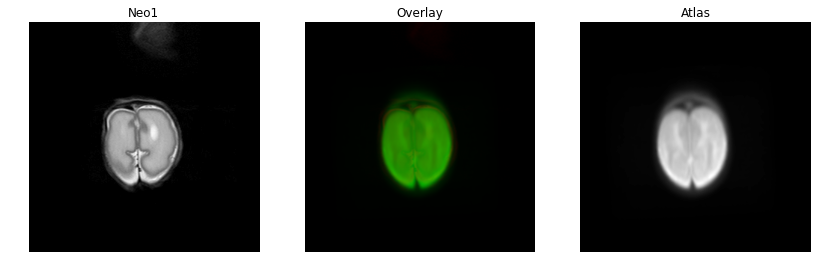

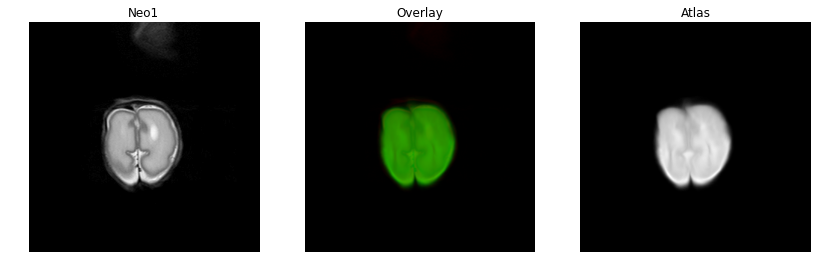

In [20]:
# Before and after diffeomorphic registration
rt.overlay_slices(neo, atlas_resampled, slice_type=2, slice_index=40, ltitle='Neo1', rtitle='Atlas');
rt.overlay_slices(neo, atlas_wcerebellum_deformed, slice_type=2, slice_index=40, ltitle='Neo1', rtitle='Atlas');

In [28]:
# Load segmentation from atlas
atlas_seg_fname = get_neobrain('atlas', 'neo-avgseg', None)
atlas_seg_nib = nib.load(atlas_seg_fname)
atlas_seg = atlas_seg_nib.get_data()
atlas_seg_affine = atlas_seg_nib.get_affine()

In [35]:
mask = (atlas_seg > 0).astype(np.int32)
mask_deformed = diff_map.transform(mask)

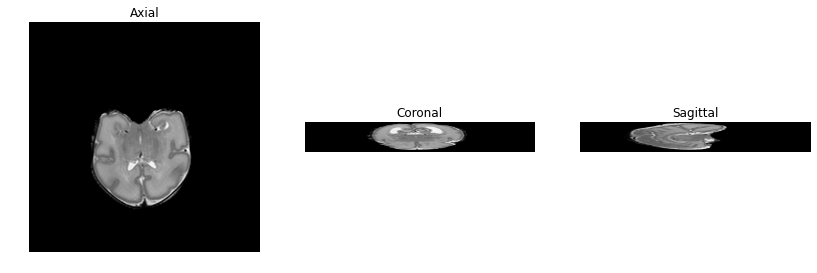

In [38]:
rt.plot_slices(neo * mask_deformed);

In [ ]:
rt.overlay_slices(neo, atlas_wcerebellum_deformed, slice_type=2, slice_index=25, ltitle='Neo1', rtitle='Atlas')